<a href="https://colab.research.google.com/github/Mukul1Panwar/Deep-Learning/blob/main/Fashion_rec(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d paramaggarwal/fashion-product-images-small

Dataset URL: https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-small
License(s): MIT
 92% 520M/565M [00:02<00:00, 179MB/s]
100% 565M/565M [00:02<00:00, 212MB/s]


In [ ]:
!unzip /content/fashion-product-images-small.zip

Streaming output truncated to the last 5000 lines.
  inflating: myntradataset/images/5813.jpg  
  inflating: myntradataset/images/58131.jpg  
  inflating: myntradataset/images/58132.jpg  
  inflating: myntradataset/images/58133.jpg  
  inflating: myntradataset/images/58135.jpg  
  inflating: myntradataset/images/58136.jpg  
  inflating: myntradataset/images/58137.jpg  
  inflating: myntradataset/images/58138.jpg  
  inflating: myntradataset/images/58139.jpg  
  inflating: myntradataset/images/5814.jpg  
  inflating: myntradataset/images/58140.jpg  
  inflating: myntradataset/images/58141.jpg  
  inflating: myntradataset/images/58143.jpg  
  inflating: myntradataset/images/58144.jpg  
  inflating: myntradataset/images/58145.jpg  
  inflating: myntradataset/images/58146.jpg  
  inflating: myntradataset/images/58147.jpg  
  inflating: myntradataset/images/58148.jpg  
  inflating: myntradataset/images/58149.jpg  
  inflating: myntradataset/images/5815.jpg  
  inflating: myntradataset/image

In [ ]:
import os

In [ ]:
images = os.listdir("/content/myntradataset/images/")

In [ ]:
from tensorflow.keras.preprocessing import image

In [ ]:
img = image.load_img(os.path.join("/content/myntradataset/images/", images[3]))

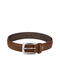

In [ ]:
img

In [ ]:
import numpy as np

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# preprocess_input: it is required because pre-trained models expect images in the same format they were trained on.

In [ ]:
base_model = ResNet50(
    weights = "imagenet",
    include_top = False,
    pooling = "avg"
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [ ]:
base_model.trainable = False # during the training we do not want to update the weights

In [ ]:
# create the embedding of image dataset

In [ ]:
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

In [ ]:
generator = datagen.flow_from_directory(
    "/content/myntradataset/",
    target_size = (224,224),
    batch_size = 32,
    shuffle = False
)

Found 44441 images belonging to 1 classes.


In [ ]:
embeddings = base_model.predict(generator,verbose=1)  # It passes your entire image dataset (in batches) through the pre-trained CNN and returns a numerical embedding vector for every image.

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1389/1389 ━━━━━━━━━━━━━━━━━━━━ 132s 90ms/step


In [ ]:
type(embeddings)

numpy.ndarray

In [ ]:
embeddings.shape # 2048 are the fixed no. of feature in RESNET50

(44441, 2048)

In [ ]:
embeddings[0]

array([0.        , 0.50175   , 0.01689659, ..., 0.19428408, 0.5179237 ,
       2.6697125 ], dtype=float32)

In [ ]:
from sklearn.preprocessing import normalize

In [ ]:
embeddings = normalize(embeddings,axis=1)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
# Cosine similarity measures how similar two vectors are in direction (angle), not probability.
'''1.0 → very similar (almost same image)

0.0 → not similar

-1.0 → opposite (rare for image embeddings)'''

'1.0 → very similar (almost same image)\n\n0.0 → not similar\n\n-1.0 → opposite (rare for image embeddings)'

In [ ]:
# query_emb.reshape(1,-1) : it converts 1d array to 2d array
# (2048,) is 1D , cosine expects 2D(x_samples,x_feature) -> (1,2048)
# (1,-1) 1: no. of rows(no. of image i.e, one image), -1 : auto. figureout the no. of col.(feature)

In [ ]:
# query_emb is the input emb and embeddings is the whole dataset
def rec(query_emb, embeddings , top_k=5):
  similarities = cosine_similarity(query_emb.reshape(1,-1),embeddings)[0]

  sort_indices = np.argsort(similarities)[::-1] # argsort sort asc. we need to reverse it to take first 5

  top_indices = sort_indices[1: top_k +1] # skip the 0 coz its a same image

  return top_indices

In [ ]:
embeddings.shape

(44441, 2048)

In [ ]:
# now user upload the image

In [ ]:
def image_upload(input_img,model):
  img = image.load_img(input_img,target_size=(224,224))
  img = image.img_to_array(img)
  img = np.expand_dims(img,axis=0)
  img = preprocess_input(img)

  emb = model.predict(img)
  emb = normalize(emb,axis=1)

  return emb

In [ ]:
image_path = "/content/mukul_image.jpg"
input_image = image_upload(image_path,base_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


In [ ]:
input_image.shape

(1, 2048)

In [ ]:
top_indices = rec(input_image,embeddings)
top_indices # indices of similar images

array([ 5473, 16606,  9052, 25232,  5094])

In [ ]:
image_files = generator.filenames # map the indices to the images
rec_images = [image_files[i] for i in top_indices]

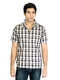

In [ ]:
image.load_img(rec_images[0])

In [ ]:
from google.colab.patches import cv2_imshow
import cv2

In [ ]:
from matplotlib import pyplot as plt

Upload the image path: /content/shoes.jpg


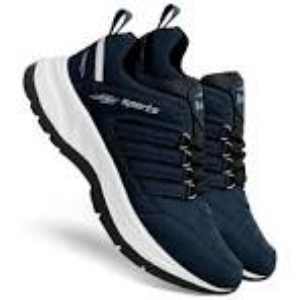

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Similar Images:


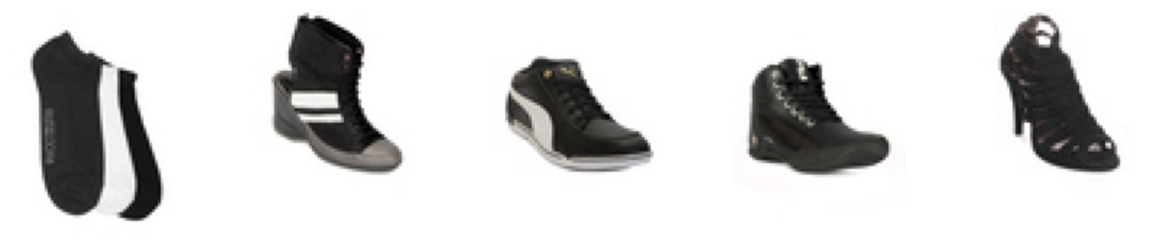

In [ ]:
uploaded_image = input("Upload the image path: ")
image_data = cv2.imread(uploaded_image)
image_data = cv2.resize(image_data,(300,300))
cv2_imshow(image_data)

###

input_image = image_upload(uploaded_image,base_model)
top_indices = rec(input_image,embeddings)
img_files = generator.filenames
similar_images = [img_files[i] for i in top_indices]


print("Similar Images:")

plt.figure(figsize=(15, 3))

for i, img_path in enumerate(similar_images):
    full_img_path = os.path.join("/content/myntradataset/", img_path)
    img = image.load_img(full_img_path)

    plt.subplot(1, len(similar_images), i + 1)
    plt.imshow(img)
    plt.axis("off")

plt.show()